# Intro

This notebooks shows my best model for the competition, it does not include the bayesian optimization itself since it was performed using Optuna in Kaggle due to hardware constraints.

# Imports and Loading Data

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import pyarrow.parquet as pq
import random
import gc

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

import lightgbm as lgb
import optuna

In [2]:
# Setting seed
SEED = 42

np.random.seed(SEED)
random.seed(SEED)

In [3]:
# Batch size
batch_size = 10000  

# Function to read the file in batches and concatenate the DataFrames
def load_parquet_in_chunks(filename, batch_size):
    parquet_file = pq.ParquetFile(filename)
    chunks = [batch.to_pandas() for batch in parquet_file.iter_batches(batch_size)]
    return pd.concat(chunks, ignore_index=True)

# Load the files in chunks
data = load_parquet_in_chunks("data_for_optuna.parquet", batch_size)
data_test = load_parquet_in_chunks("data_test_for_optuna.parquet", batch_size)

# Verify that the DataFrames were loaded correctly
print(data.shape, data_test.shape)

(492020, 1098) (163520, 1097)


# Models

Creating 10 stratified folds based on whether a time series has a flood or not (keeping all records from each time series on its fold)

In [4]:
def stratified_event_cv(data, num_folds=10):
    # Create a mapping of event_id to its label (1 if it contains any label=1, else 0)
    event_labels = data.groupby('event_id')['label'].max()

    # Initialize StratifiedKFold
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=SEED)
    
    # Assign fold numbers at the event level
    event_folds = {}
    for fold, (train_idx, val_idx) in enumerate(skf.split(event_labels.index, event_labels.values)):
        for event_id in event_labels.index[val_idx]:
            event_folds[event_id] = fold  # Assign the whole event to a fold
    
    # Apply fold assignment to the original data
    data['fold'] = data['event_id'].map(event_folds)

    return data

data = stratified_event_cv(data, num_folds = 10)

## Classifying in time series with and without flood CV

As features for this model I took:
* All image related features (stats + GLCM features).
* Aggregated stats of precipitation.

In [5]:
glcm_terms = ['Contrast', 'Correlation', 'Homogeneity', 'Entropy', 'ASM']
glcm_cols = [col for col in data.columns if any(col.endswith(term) for term in glcm_terms)]

stats_terms = ['mean', 'std', 'kurtosis', 'skew', 'min', 'max', 'p10', 'p25', 'p50', 'p75', 'p90']
stats_cols = [col for col in data.columns if any(col.endswith(term) for term in stats_terms)]

precipitation_cols = ['precipitation_percentage']

In [6]:
# Perform aggregation as before
data_selected = data.groupby('event_id').agg({
    **{col: 'first' for col in precipitation_cols},
    **{col: 'first' for col in glcm_cols},
    **{col: 'first' for col in stats_cols},
    'fold': 'first',
    'label': 'max'  # Use 'max' for label aggregation
}).reset_index()

In [7]:
mc1 = precipitation_cols + glcm_cols + stats_cols
mc1 = list(set(mc1))

In [8]:
# Ensure that the 'label' column is binary
X = data_selected[mc1]
y = data_selected['label']

# Store accuracy results for each fold
accuracies = []
predictions = []
feature_importances = []

# Start the cross-validation process using the existing folds
for fold in range(data_selected['fold'].nunique()):
    # Filter data for the current fold
    train_data = data_selected[data_selected['fold'] != fold]
    val_data = data_selected[data_selected['fold'] == fold]
    
    # Separate features and labels
    X_train, y_train = train_data[mc1], train_data['label']
    X_val, y_val = val_data[mc1], val_data['label']
    
    # Create datasets for LightGBM
    train_set = lgb.Dataset(X_train, label=y_train)
    val_set = lgb.Dataset(X_val, label=y_val, reference=train_set)
    
    # Define LightGBM parameters (basic values)
    params = {
        'objective': 'binary',
        'metric': 'binary_error',  # Use binary_error for binary classification
        'boosting_type': 'gbdt',
        'num_leaves': 36, 
        'learning_rate': 0.16222004068204626, 
        'feature_fraction': 0.9624627336499201, 
        'bagging_fraction': 0.8276937924215806, 
        'bagging_freq': 8, 
        'num_iterations': 323,
        'verbose': -1,
        'early_stopping_rounds': 50,
        'random_state': SEED
    }

    # Train the model
    model = lgb.train(params, train_set, valid_sets=[val_set])
    
    # Predictions on the validation set (probabilities)
    y_pred_probs = model.predict(X_val, num_iteration=model.best_iteration)
    
    # Convert probabilities to binary predictions
    y_pred_binary = np.round(y_pred_probs)
    accuracy = accuracy_score(y_val, y_pred_binary)
    accuracies.append(accuracy)
    
    # Store predictions with event_id and predicted probabilities
    temp_df = val_data[['event_id']].copy()
    temp_df['pre_class'] = y_pred_probs
    predictions.append(temp_df)
    
    # Store feature importances for the current fold
    fold_importance = model.feature_importance(importance_type='split')  # Or 'gain' for gain-based importance
    fold_importance_percentage = 100 * fold_importance / fold_importance.sum()  # Normalize to percentage
    feature_importances.append(fold_importance_percentage)

# Compute the average accuracy
print(f"Average Accuracy: {np.mean(accuracies)}")

# Concatenate all predictions into a single DataFrame
class_predictions = pd.concat(predictions, ignore_index=True)

# Compute the average feature importances (mean across folds)
average_feature_importances = np.mean(feature_importances, axis=0)

c:\Users\ifake\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\ifake\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\ifake\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\ifake\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

Average Accuracy: 0.9111062335381914


Feature importances of the model

In [9]:
# Display feature importances in percentage
feature_importance_df = pd.DataFrame({
    'feature': mc1,
    'importance': average_feature_importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Display top 10 features
print(feature_importance_df.head(50))

                      feature  importance
221         precipitation_std    3.750415
135                    B2_max    3.732424
107        precipitation_mean    2.933301
0           B11_B4_Ratio_mean    2.520352
172           B4_B3_Ratio_max    2.054432
270        B8_i_1_Correlation    1.719409
182                  NDWI_std    1.716115
9          B2_i_1_Correlation    1.502261
62         B3_i_1_Correlation    1.460002
99                   SAVI_std    1.406445
104                  RDVI_std    1.364090
27         precipitation_skew    1.290464
260          B8_B2_Ratio_skew    1.254397
59        B11_i_1_Homogeneity    1.219128
81                   BSI_mean    1.189261
6                   NDWI_skew    1.176798
143                  MMSR_std    1.149199
83                   MMSR_min    1.137674
133         precipitation_max    1.101607
256                   BSI_p50    1.059541
249                    B2_std    0.953031
111          B8_B3_Ratio_skew    0.908964
239                   EVI_std    0

The images seem to be pretty important in assesing the risk of a flash flood in a location

Also, since each time series has AT MOST one flood. We can lower the log loss by normalizing the probabilities so they sum 1 on the time series, ONLY for the locations that were predicted as having one flood.

In [10]:
# Saving RAM
del data_selected, X, y, accuracies, predictions, X_train, y_train, X_val, y_val, train_set, val_set, model, y_pred_probs, y_pred_binary, temp_df

# Garbage collection
gc.collect()

216

## Flash Flood CV with LightGBM

Since my pc takes a while to load models, I tried different combinations of precipitation related features using Optuna on Kaggle to obtain the best hyperparameters and features for the model. Here, the cross validation for the best model is shown. Its features are:
* All image related features.
* All 365 leads and lags.
* Rolling statistics: exponential mean, sum, max, median, std.
* Ratio of the precipitation between two consecutive precipitation days.
* Aggregated stats of precipitation time series: mean, max, std, kurtosis, skew and percentage of days with rain.
* Day related features: consecutive days with rain, number of days since it last rained.

In [11]:
glcm_terms = ['Contrast', 'Correlation', 'Homogeneity', 'Entropy', 'ASM']
glcm_cols = [col for col in data.columns if any(col.endswith(term) for term in glcm_terms)]

stats_terms = ['mean', 'std', 'kurtosis', 'skew', 'min', 'max', 'p10', 'p25', 'p50', 'p75', 'p90']
stats_cols = [col for col in data.columns if any(col.endswith(term) for term in stats_terms)]

m1 = ([col for col in data.columns if col.startswith('precipitation')] + glcm_cols + stats_cols )
m1 = list(set(m1))
m1 += ['event_t', 'consecutive_rainy_days', 'after_rain_days',  'rain_ratio']
m1 = [col for col in m1 if not (col.startswith("precipitation_lag_mean") or col.startswith("precipitation_lead_mean"))]

In [12]:
# Initialize the model hyperparameters
param_lgb = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'device': 'cpu',
    'max_depth': 3,
    'learning_rate': 0.02109231310957362,
    'num_iterations': 937,
    'bagging_fraction': 0.5958550528828465,
    'feature_fraction': 0.7517370100971414,
    'min_child_samples': 40,
    'lambda_l1': 0.09355028973263738,
    'lambda_l2': 0.38495417491314887,
    'verbosity': -1,
    'seed': SEED
}

# Inicializar listas para almacenar resultados
log_losses = []
predictions_list = []

# Entrenar modelos con validación cruzada
for fold in range(10):  
    mask = data['fold'] != fold  
    X_train = data.loc[mask, m1]
    y_train = data.loc[mask, 'label']
    
    # Crear y entrenar el modelo
    model = lgb.LGBMClassifier(**param_lgb)
    model.fit(X_train, y_train)
    
    # Obtener datos de validación
    mask_val = data['fold'] == fold
    X_val = data.loc[mask_val, m1]
    y_val = data.loc[mask_val, 'label']
    event_id = data.loc[mask_val, 'event_id']
    event_t = data.loc[mask_val, 'event_t']
    
    # Predecir
    y_pred = model.predict_proba(X_val)[:, 1]
    
    # Guardar log loss
    fold_log_loss = log_loss(y_val, y_pred)
    log_losses.append(fold_log_loss)
    
    # Guardar predicciones
    predictions_list.append(pd.DataFrame({
        'event_id': event_id.values,
        'event_t': event_t.values,
        'label': y_val.values,
        'predicted_prob': y_pred
    }))

    print(f"Log loss for fold {fold}: {fold_log_loss}")

    # **Liberar memoria**
    del X_train, y_train, X_val, y_val, event_id, event_t, y_pred, mask, mask_val, model
    gc.collect()
    
# Combine all fold predictions into a single DataFrame
all_predictions = pd.concat(predictions_list, ignore_index=True)

# Calculate and print the average log loss
average_log_loss = np.mean(log_losses)
print(f"Average log loss across all folds: {average_log_loss}")

c:\Users\ifake\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Log loss for fold 0: 0.002570203330659267


c:\Users\ifake\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Log loss for fold 1: 0.002814204358561539


c:\Users\ifake\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Log loss for fold 2: 0.0026946646839395073


c:\Users\ifake\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Log loss for fold 3: 0.0024634313318154326


c:\Users\ifake\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Log loss for fold 4: 0.0026646839392374818


c:\Users\ifake\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Log loss for fold 5: 0.001806948302819706


c:\Users\ifake\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Log loss for fold 6: 0.002595575018948783


c:\Users\ifake\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Log loss for fold 7: 0.0028542093762859906


c:\Users\ifake\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Log loss for fold 8: 0.002329090373857824


c:\Users\ifake\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Log loss for fold 9: 0.0023652159119908955
Average log loss across all folds: 0.0025158226628116424


Now that we have the predictions per fold, I can normalize the probabilities for event_id predicted as having a flood.

In [18]:
all_predictions = all_predictions.merge(class_predictions, how='left', on=['event_id'])

In [ ]:
# Selecting records to normalize
mask = all_predictions['pre_class'] > 0.5

# Grouping by event_id and calculating the sum of predicted_prob
sum_prob = all_predictions[mask].groupby('event_id')['predicted_prob'].transform('sum')
all_predictions.loc[mask, 'predicted_prob'] = all_predictions.loc[mask, 'predicted_prob'] / sum_prob

In [23]:
all_predictions = all_predictions.merge(data[['event_id', 'event_t', 'fold']], how='left', on=['event_id', 'event_t'])

Calculating log loss per fold and averaging.

In [25]:
avg_log_loss = (
    all_predictions.groupby("fold")
    .apply(lambda x: log_loss(x["label"], x["predicted_prob"], labels=[0, 1]))
    .mean()
)

print(f"Average log loss across all folds: {avg_log_loss:.19f}")

Average log loss across all folds: 0.0024288010248819090


C:\Users\ifake\AppData\Local\Temp\ipykernel_1648\2222925633.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: log_loss(x["label"], x["predicted_prob"], labels=[0, 1]))


As you can see, it lowers the CV log loss by 0.00008702163, aproximately a 3.45% improvement.

# Checking Predictions

As a bonus, this is the function I used to check how shifted my predictions were. As you can see, in some cases the flood is predicted a few days before or afterwards the actual flash flood. Sadly, since i joined the challenge late, this was a problem I had no time to solve.

In [40]:
def plot_predictions_for_event(event_id, predictions_df):
    # Filter the DataFrame for the specified event_id
    event_data = predictions_df[predictions_df['event_id'] == event_id]
    
    # Ensure the event_id has at least one label = 1
    if event_data['label'].sum() == 0:
        print(f"Warning: event_id {event_id} has no label = 1.")
        return
    
    # Get the event_t values where label = 1
    label_1_points = event_data[event_data['label'] == 1]

    # Get the top 3 highest predicted probability points
    top_3_probs = event_data.nlargest(3, 'predicted_prob')

    # Create the first plot: label across event_t
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='event_t', y='label', data=event_data, marker='o', label="Actual Label")
    plt.title(f'Label across Event ID: {event_id}')
    plt.xlabel('Event Time (event_t)')
    plt.ylabel('Label (0 or 1)')
    plt.xticks(rotation=45)
    
    # Annotate points where label = 1
    for _, row in label_1_points.iterrows():
        plt.text(row['event_t'], row['label'], f"{row['event_t']}", 
                 ha='right', va='bottom', fontsize=10, bbox=dict(facecolor='white', alpha=0.6))

    plt.tight_layout()
    plt.show()

    # Create the second plot: predicted probabilities across event_t
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='event_t', y='predicted_prob', data=event_data, marker='o', label="Predicted Probability", color='orange')
    plt.title(f'Predicted Probabilities across Event Time (event_id: {event_id})')
    plt.xlabel('Event Time (event_t)')
    plt.ylabel('Predicted Probability')
    plt.xticks(rotation=45)
    
    # Annotate the top 3 highest predicted probability points
    for _, row in top_3_probs.iterrows():
        plt.text(row['event_t'], row['predicted_prob'], f"{row['event_t']}", 
                 ha='right', va='bottom', fontsize=10, bbox=dict(facecolor='white', alpha=0.6))

    plt.tight_layout()
    plt.show()

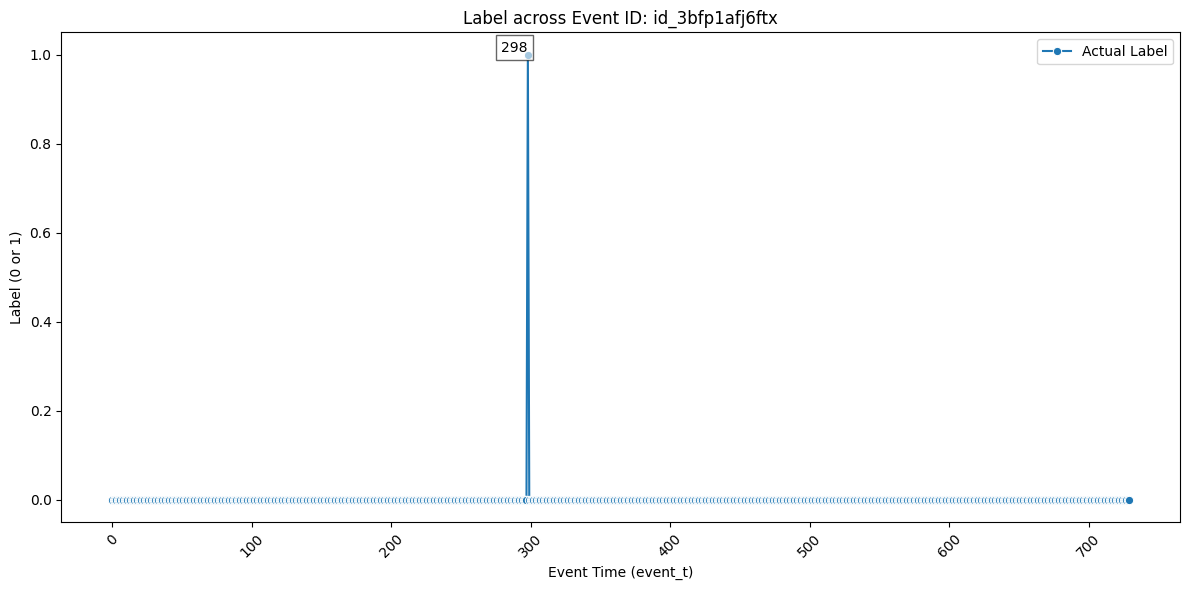

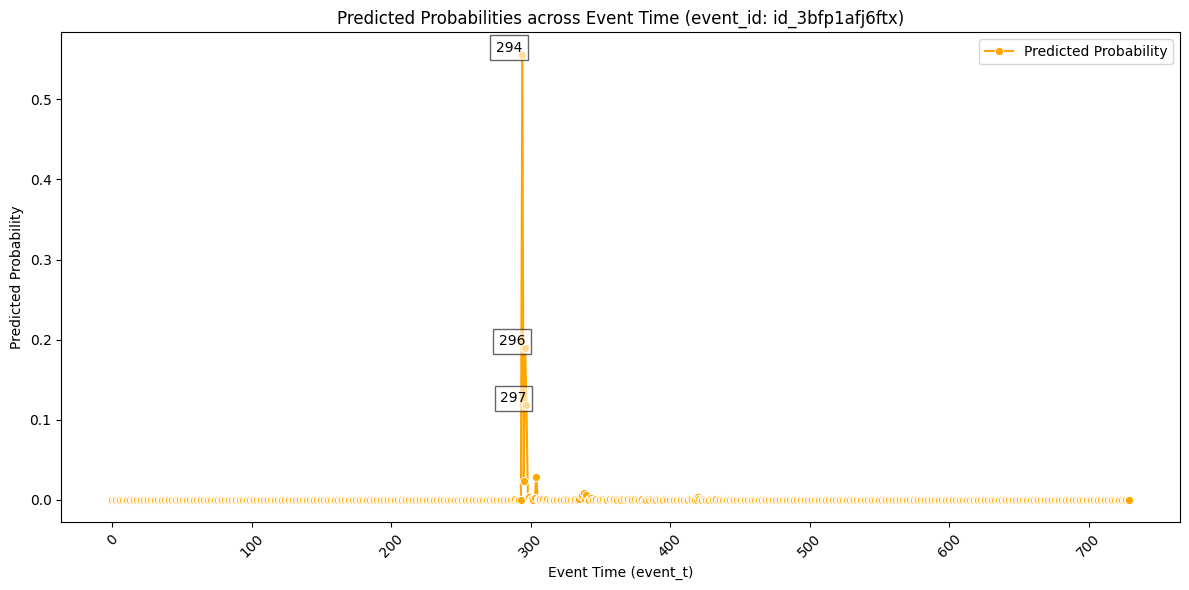

In [51]:
plot_predictions_for_event(event_id='id_3bfp1afj6ftx', predictions_df=all_predictions)